

**THIS IS NOT THE COMPLETE TUTORIAL - see file with (MAIN) in the name. Paste all this code before the first Python block**

First you'll need to select which hardware setup you have. You'll need to select both a `SCOPETYPE` and a `PLATFORM`. `SCOPETYPE` can either be `'OPENADC'` for the CWLite/CW1200 or `'CWNANO'` for the CWNano. `PLATFORM` is the target device, with `'CWLITEARM'`/`'CW308_STM32F3'` being the best supported option, followed by `'CWLITEXMEGA'`/`'CW308_XMEGA'`, then by `'CWNANO'`. As of CW 5.4, you can select the SimpleSerial version
used. For example:

```python
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
SS_VER = 'SS_VER_2_1'
```

In [19]:
SCOPETYPE = 'OPENADC'
#PLATFORM = 'CWLITEARM'
PLATFORM = 'CWLITEARM'
SS_VER = 'SS_VER_2_1'
import os
#os.chdir('C:/Users/prith/ChipWhisperer5_64/cw/home/portable/chipwhisperer/jupyter/courses/sca101')

This code will connect the scope and do some basic setup. We're now just going to use a special setup script to do this. This script contains the commands we ran seperately before.

In [79]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.
INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.
INFO: Found ChipWhisperer😍


The following code will build the firmware for the target.

In [81]:
import os
os.chdir('../../../hardware/victims/firmware/NN-Wireless')

!make PLATFORM=CWLITEARM CRYPTO_TARGET=NONE SS_VER=SS_VER_2_1
#!make PLATFORM=CWLITEXMEGA CRYPTO_TARGET=NONE SS_VER=SS_VER_2_1

SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
make[1]: '.dep' is up to date.
SS_VER set to SS_VER_2_1
SS_VER set to SS_VER_2_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10-2020-q4-major) 10.2.1 20201103 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
    basic-NN2.c ...Done!
.
Compiling:
    .././simpleserial/simpleserial.c ...Done!
.
Compiling:
    .././hal/stm32f3/stm32f3_hal.c ...Done!
.
Compiling:
    .././hal/stm32f3/stm32f3_hal_lowlevel.c ...Done!
.
Compiling:
    .././hal/stm32f3/stm32f3_sysmem.c ...Done!
.
Assembling: .././hal/stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -DF_CPU=7372

basic-NN2.c: In function 'main':
basic-NN2.c:288:14: warning: variable 'count' set but not used [-Wunused-but-set-variable]
  288 |     uint16_t count = 0;
      |              ^~~~~


Finally, all that's left is to program the device, which can be done with the following line:

In [82]:
cw.program_target(scope, prog, "basic-NN2-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 16187 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 16187 bytes


To make interacting with the hardware easier, let's define a function to attempt a password and return a power trace:

We also don't need all of the default 5000 samples in the trace. 3000 is a good starting point for most targets:

In [83]:
scope.adc.samples = 3000
os.chdir("../../../../new_download_chipwhisperer_jupyter/courses/sca101/")

In [84]:
#for float in 0.xx format
f = open("wireless_preprocessed_approx.csv",'r')

c= 0
label = []
features_string = []
for line in f :
    if c<=2 :
        print(line)
    if c >=1 :# and c<10 :
        features_label = line.split(",")
#        print(features)
        l = len(features_label)
        label.append(features_label[l-1])
        f_s = ""
        for i in range(0,l-1):
            if i != 0 :
                f_s = f_s +", "+ str(int(float(features_label[i].replace("\n",""))))
            else :
                f_s = f_s + str(int(float(features_label[i].replace("\n",""))))
        features_string.append(f_s)
    c = c+ 1

feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,class

1,474,604,343,0,292,920,7,0

1,474,604,343,0,324,232,3,0



In [85]:
import random

# Create a dictionary to store samples for each class
class_samples = {l.strip(): [] for l in set(label)}

# Populate the dictionary with samples
for l, sample in zip(label, features_string):
    class_samples[l.strip()].append(sample)

# Filter 20 samples for each class
filtered_samples = {label: random.sample(samples, 25) for label, samples in class_samples.items() if len(samples) >= 25}

In [86]:
# scope.dis()
# target.dis()
#
# DEFINE THE cap_pass_trace() function - either using a hardware connection or the file read-out.
#
def cap_pass_trace(pass_guess):
    reset_target(scope)
    num_char = target.in_waiting()
    m = ""
    while num_char > 0:
        m = target.read(num_char, 10)
#        time.sleep(0.1)
        time.sleep(3.0)
        num_char = target.in_waiting()
        #print(m)
    
#     print(target.read)
    scope.arm()
    target.write(pass_guess)
    ret = scope.capture()
    if ret:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace, m

#raise NotImplementedError("Add your code here, and delete this.")
# print(len(features_string[1]))
# print(features_string[1])
trace_test,m = cap_pass_trace(features_string[1]+"\n")


#65368
print(m)
print(len(m))
#Basic sanity check
assert(len(trace_test) == 3000)
print("✔️ OK to continue!")

  
2
✔️ OK to continue!


In [87]:
trace_list = []
pred_list = []
print(len(label))
c = 0
for i in filtered_samples.keys():
    print(i)
    for feature in filtered_samples[i]:
        trace_h,m = cap_pass_trace(feature+"\n")
        time.sleep(1)
        trace_list.append(trace_h)
        pred_list.append(m)
        c = c  + 1
print(pred_list)

52482
0
3
2
1
['4´ÍÖ\x01Ú\\W\x00', '4´ÍÖ\x01ïOy\x00', '3´ÍÖ\x01Ej.\x00', '4´ÍÖ\x01ß\\r\x00', '0´ÍÖ\x01*/B\x00', '3´ÍÖ\x00', '4´ÍÖ\x01ïOW\x00', '0´ÍÖ\x00', '4´ÍÖ\x01ªn\x04\x00', '4´ÍÖ\x01ßO\x80\x00', '4´ÍÖ\x01ÊaP\x00', '4´ÍÖ\x00', '4´ÍÖ\x00', '4´ÍÖ\x01ä\\;\x00', '4´ÍÖ\x01Úa^\x00', '1´ÍÖ\x01\x9anÍ\x00', '4´ÍÖ\x00', '4´ÍÖ\x01TA\x0b\x03D©\x08i+àÂªDvÃÛ@ÚÃM\x9fJÃ\x00', '4´ÍÖ\x00', '4´ÍÖ\x01´s;\x00', '4´ÍÖ\x00', '0´ÍÖ\x01/8\x95\x00', '4´ÍÖ\x00', '4´ÍÖ\x00', '4´ÍÖ\x01´j^\x00', '3´ÍÖ\x00', '4´ÍÖ\x015ÀW\x01UÎ\x07\x0b\x06HÃDîÂÁ/\x9c`ÄÝ\x07QÂ\x00', '3´ÍÖ\x00', '0´ÍÖ\x00', '4´ÍÖ\x01z\\B\x00', '4´ÍÖ\x00', '4´ÍÖ\x00', '0´ÍÖ\x00', '4´ÍÖ\x01ÏSÅ\x01Ê\x12\t\x809ùÃT\x06LÄÖP5Ä3F²Á\x00', '4´ÍÖ\x00', '4´ÍÖ\x01ï\x8ak\x01Ê\r\x07§2ÛÃr*0ÄÀÎRÄ³ÇaÃ\x00', '0´ÍÖ\x01\x8f\\Ô\x01êT\nGØ\x14Ä\x1bR^ÄÙù;ÄL\x0b\x01C\x00', '0´ÍÖ\x00', '4´ÍÖ\x00', '4´ÍÖ\x00', '3´ÍÖ\x00', '4´ÍÖ\x01$\x1d\x17\x00', '4´ÍÖ\x00', '4´ÍÖ\x00', '0´ÍÖ\x00', '4´ÍÖ\x01ÔE\x9b\x00', '3´ÍÖ\x00', '4´ÍÖ\x01´sâ\x01a\x95\x03`m¼ÃÄ×\x96Â®t^ÄVUJÃ\x00', '3´ÍÖ\x00',

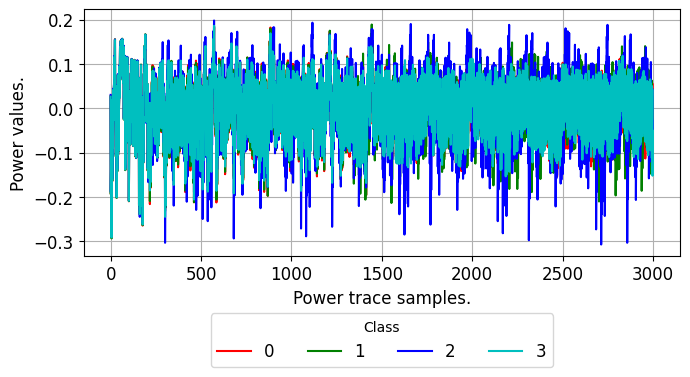

In [90]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np

color=['r','g','b','c','y','m','k','r','g','b']
plt.figure(figsize=(7,4))
for i in range(4):
    plt.plot(np.mean(np.array(all_sum[i]), axis=0), label = f'{i}', c=color[i])
plt.grid()
plt.legend(title = "Class", ncol=5, fontsize=12, bbox_to_anchor=(0.5, -0.2), loc='upper center')
plt.xlabel('Power trace samples.', fontsize=12)
plt.ylabel('Power values.', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('power_per_class.pdf')
plt.show()

In [91]:
Average_across_samples = {}
for i in range(4):
    Average_across_samples[i] = np.mean(np.array(all_sum[i]))
print('Average power: ',Average_across_samples)

# Sorting the dictionary by values
sorted_dict = dict(sorted(Average_across_samples.items(), key=lambda item: abs(item[1])))

print("Sorted average power:", sorted_dict)

Average power:  {0: -0.007246875, 1: -0.007443684895833334, 2: -0.0072545572916666665, 3: -0.007218977864583333}
Sorted average power: {3: -0.007218977864583333, 0: -0.007246875, 2: -0.0072545572916666665, 1: -0.007443684895833334}


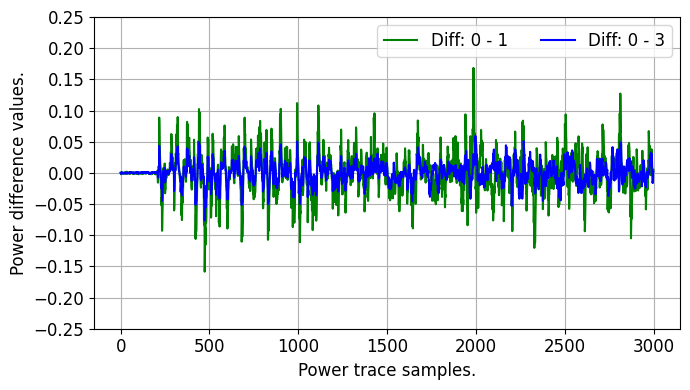

In [32]:
import matplotlib.pyplot as plt
from ipywidgets import interact

avg = {}
for i in range(5):
    avg[i] =  np.mean(np.array(all_sum[i]), axis=0)

plt.figure(figsize=(7,4))

avg_diff_0_1 = avg[0]-avg[1]
avg_diff_0_2 = avg[0]-avg[2]
avg_diff_0_3 = avg[0]-avg[3]
    
plt.plot(avg_diff_0_1, label = "Diff: 0 - 1", c='g')
#plt.plot(avg_diff_0_3, label = "diff 0 - 3", c='r')
plt.plot(avg_diff_0_3, label = "Diff: 0 - 3", c='b')
#plt.plot(avg_0, label = "0", c='r')
plt.legend(ncol=2, fontsize=12)
plt.grid()
plt.ylim([-0.25,0.25])
plt.yticks([-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25], fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Power trace samples.', fontsize=12)
plt.ylabel('Power difference values.', fontsize=12)
plt.tight_layout()
plt.savefig('power_diff.pdf')
plt.show()

#### CPA Analysis for Weight Estimation.

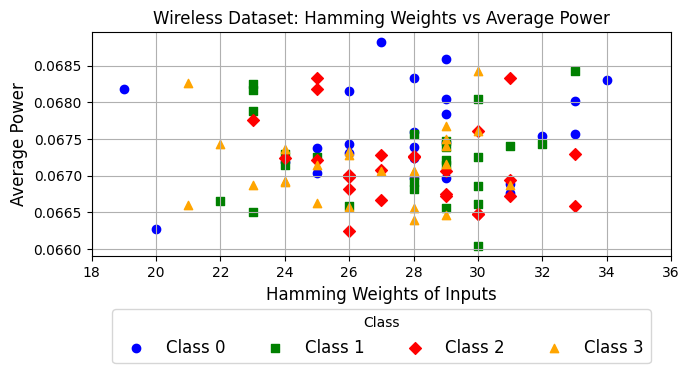

In [108]:
# Define the Hamming weight function
def hamm_weight(feature):
    feature = feature.split(',')
    feature = [int(i.strip()) for i in feature]
    feature = ''.join([bin(x) for x in feature])
    return feature.count('1')

hamming_weights = []
average_power = []
for i in filtered_samples.keys():
    for feature in filtered_samples[i]:
        hamming_weights.append(hamm_weight(feature))
        
for i in range(len(hamming_weights)): 
    average_power.append(sum(abs(x) for x in trace_list[i]) / len(trace_list[i]))
    #average_power.append(np.mean(trace_list[i]))

# Create a scatter plot
plt.figure(figsize=(7,4))
#plt.scatter(hamming_weights, average_power, color='blue', marker='o')
# Define colors and markers for each class
colors = ['blue', 'green', 'red', 'orange']
markers = ['o', 's', 'D', '^']
labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Create scatter plots for each class
for i in range(4):
    start_index = i * 25
    end_index = (i + 1) * 25
    plt.scatter(hamming_weights[start_index:end_index], 
                average_power[start_index:end_index], 
                color=colors[i], 
                marker=markers[i], 
                label=labels[i])

# Add labels and title
plt.xlabel('Hamming Weights of Inputs', fontsize=12)
plt.ylabel('Average Power', fontsize=12)
plt.title('Wireless Dataset: Hamming Weights vs Average Power', fontsize=12)
plt.xticks([18, 20, 22, 24, 26, 28, 30, 32, 34, 36])
#plt.legend(ncol = 2)
plt.legend(title = "Class", ncol=5, fontsize=12, bbox_to_anchor=(0.5, -0.2), loc='upper center')
# Show the plot
plt.grid(True)
plt.tight_layout()
plt.savefig('Correlation_plot.pdf')
plt.show()

In [53]:
trace_list = np.array(trace_list)
hamming_weights = np.array(hamming_weights)

In [64]:
import numpy as np
from scipy.stats import pearsonr

# Define the range of possible weight guesses
weight_guesses = np.linspace(-1, 1, 1000)  # Adjust the range and resolution as needed

# Perform correlation power analysis (CPA)
def cpa(trace_list, hamming_weights, weight_guesses):
    num_samples, num_points = trace_list.shape
    num_guesses = len(weight_guesses)
    correlations = np.zeros((num_guesses, num_points))

    for guess_idx, weight_guess in enumerate(weight_guesses):
        # Hypothetical power consumption
        # Introduce randomness in the hypothetical power consumption
        hypothetical_consumption = hamming_weights * weight_guess + np.random.normal(-1, 1, hamming_weights.shape)


        for point in range(num_points):
            trace_point_values = trace_list[:, point]
            correlation, _ = pearsonr(trace_point_values, hypothetical_consumption)
            correlations[guess_idx, point] = correlation

    return correlations

# Calculate correlations
correlations = cpa(trace_list, hamming_weights, weight_guesses)

# Find the weight guess and point with the highest correlation
max_correlation_index = np.unravel_index(np.argmax(correlations), correlations.shape)
best_weight_guess = weight_guesses[max_correlation_index[0]]
max_correlation_value = correlations[max_correlation_index]

print(f"Maximum correlation is at weight guess {best_weight_guess} with value {max_correlation_value}")

# Identify the layer and weight index
predicted_weight_layer = "Dense layer 1"
predicted_weight_index = max_correlation_index[1] % 100  # Assuming we are predicting weights of the first layer (100 weights)

print(f"Predicted weight index: {predicted_weight_index}")
print(f"Predicted weight belongs to: {predicted_weight_layer}")
print(f"Predicted value of the weight: {best_weight_guess}")


Maximum correlation is at weight guess -0.4714714714714715 with value 0.5777306775480295
Predicted weight index: 65
Predicted weight belongs to: Dense layer 1
Predicted value of the weight: -0.4714714714714715


In [71]:
All_weights = [-0.409644, -0.710711, -2.085330, 0.218946, 0.115179, 0.599601, -0.325085, 0.302378,
    -0.022886, -0.985281, 0.518062, 0.158357, -0.358417, -0.239548, -0.147660, 0.009089,
    -0.641172, -0.120358, -2.754416, -0.090740, -0.095734, -0.289911, -0.270638, 0.176571,
    0.209053, 0.229841, 0.434392, 0.543819, 0.706258, 1.136261, 0.206609, -0.137186,
    0.266923, 0.729215, 1.233839, 0.150938, 0.511337, 0.246002, 0.144538, 0.144622,
    0.378910, 0.147494, 0.174381, -0.408773, -1.136339, 0.655138, 0.084789, -0.066401,
    0.666381, 1.117213, -0.909594, -0.476068, 0.101761, -0.863234, 0.115786, -0.521360,
    -0.042350, -0.598295, 0.497215, 0.235099, -2.180087, 0.040306, 0.212547, -0.298637,
    -0.389208, -0.337861, -0.405585, 0.398723, 0.218717, 0.909563, 0.090572, -0.392000,
    -0.032673, 0.043109, -0.462349, -0.060018, -2.265743, 0.510537, -0.008246, -0.026670,
    0.615957, 0.191575, 0.228740, -0.244856, 0.047003, -0.097458, -0.257545, -0.896734,
    0.061064, -0.132935, -3.790369, 0.055466, -0.285962, -0.016571, 0.071944, -0.183826,
    0.576337, 0.935193, -0.166005, -0.327523, -0.239876, -0.582660, 0.084165, -0.258565,
    -0.110991, -0.145137, 0.295585, 0.453241, -0.275983, 0.224764, 0.125485, -0.035301,
    -0.066225, 0.085836, 0.315529, 0.292540, 2.655580, 0.218280, 0.056333, -0.043594,
    0.188047, 0.655666, -0.620651, -0.272982, 0.681932, 0.991872, 0.079081, -0.591655,
    0.221799, 0.075928, -0.183586, -0.096027, -0.467795, 1.521871, -0.053487, 0.189771,
    -0.156017, 0.918178, -0.385207, -0.911459, -0.421702, -0.291968, 0.170244, -0.170641,
    0.236344, -0.049352, 0.032033, -0.238226, 2.442845, -0.929640, 0.011197, -0.089384,
    -0.596474, -0.029301, -1.150287, -0.380027, -0.273297, 0.537311, 0.172596, 0.031391]
All_weights[predicted_weight_index]

-0.337861

In [109]:
correlations.shape

(1000, 3000)